This notebook illustrates the basic functionality of `TSFuse` for a synthetic time series dataset. It covers the following aspects:

- **Data Representation**<br />
The system represents a time series dataset as two components: (1) *views* which consist of the time series data, and (2) *labels* which consist of the labels assigned to the time series data. We show how to create a time series dataset in this format.
- **Feature Construction**<br />
The goal of `TSFuse` is to transform the views into a feature representation which is suitable for predicting the labels. Since we automate this step, this only requires a single function call.
- **Learning a Model**<br />
In order to predict the target label, we show how to build a model based on the constructed features. As our system only includes the feature construction step, we use `scikit-learn` for learning a model. Specifically, we train a L1-regularized linear model using the `LassoCV` regressor. This type of model can deal with a high dimensional dataset, which is useful when the number of generated features is large.

---

First, we generate a synthetic time series dataset with two input series. Each series consists of sinusoidal waves with Gaussian noise. To be precise, we generate the dataset as follows:

$x_1(t) = A_0 \cdot sin(2 \pi f_0 t) \cdot A_1 \cdot sin(2 \pi f t) + \mathcal{N}(0; 0.1^2)$

$x_2(t) = A_0 \cdot sin(2 \pi f_0 t) \cdot A_2 \cdot sin(2 \pi f t) + \mathcal{N}(0; 0.1^2)$

where the amplitures $A_0$, $A_1$ and $A_2$ and the frequencies $f_0$ and $f$ are drawn from random uniform distributions:

$A_0 \sim \mathcal{U}(10; 20)$

$A_1 \sim \mathcal{U}(1; 10)$

$A_2 \sim \mathcal{U}(1; 10)$

$f_0 \sim \mathcal{U}(0.1; 2)$

$f \sim \mathcal{U}(0.25; 1)$

We generate these series for 100 time stamps:

$t = [t_1, t_2, t_3, ..., t_{100}]$ with $t_0 = 0$ and $t_{100} = 10$

The target variable is defined as follows:

$y = \mathrm{median}\Big(\frac{A_1}{A_2}\Big) \cdot (1 + \epsilon)$

$\epsilon \sim \mathcal{U}(-0.1; 0.1)$

To build a dataset, we generate $N$ instances, i.e., $N$ times the vectors $x_1$ and $x_2$ and $N$ labels $y$. We set $N=1000$ in order to make the dataset large enough for learning an accurate model.

The following block of code implements these equations. We use the `timesynth` package to generate the sine waves and the Gaussian noise.

In [1]:
import numpy as np
import pandas as pd
import random as rand
import timesynth as ts
import matplotlib.pyplot as plt
np.random.seed(0)
rand.seed(0)

# Number of examples (each example is a window with 100 time stamps)
N = 1000

x1, x2, y = [], [], []
sampler = ts.TimeSampler(stop_time=10)
for i in range(N):
    t = sampler.sample_regular_time(num_points=100)
    
    # Random variables
    amp0 = rand.uniform(10, 20)
    amp1 = rand.uniform(1, 10)
    amp2 = rand.uniform(1, 10)
    freq0 = rand.uniform(0.1, 2)
    freq = rand.uniform(0.2, 1)
    epsilon = rand.uniform(-0.1, 0.1)
    
    # Noise for the series
    white_noise = ts.noise.GaussianNoise(std=0.1)
    
    # Main sinusoidal signal
    sinusoid = ts.signals.Sinusoidal(amplitude=amp0, frequency=freq0)
    main = ts.TimeSeries(sinusoid).sample(t)[0]
    
    # Sinusoidal signal 1
    sinusoid = ts.signals.Sinusoidal(amplitude=amp1, frequency=freq)
    s1 = ts.TimeSeries(sinusoid, noise_generator=white_noise).sample(t)[0]
    x1.append(s1 * main)
    
    # Sinusoidal signal 2
    sinusoid = ts.signals.Sinusoidal(amplitude=amp2, frequency=freq)
    s2 = ts.TimeSeries(sinusoid, noise_generator=white_noise).sample(t)[0]
    x2.append(s2 * main)
    
    # Target variable
    y.append(np.nanmedian(s1 / s2) * (1 + epsilon))

Let's see what these series look like by plotting the first instance.

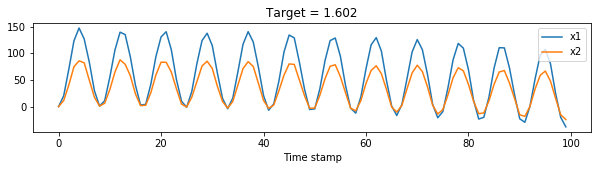

In [2]:
plt.figure(figsize=(10, 2))
plt.plot(x1[0], label='x1')
plt.plot(x2[0], label='x2')
plt.xlabel('Time stamp')
plt.title('Target = {}'.format(round(y[0], 3)))
plt.legend()
plt.show()

# Data Representation

In `TSFuse` a time series dataset consists of views `X` with numerical time series data and labels `y` with categorical or numerical target data.

## Views

The views are represented as a `dict` which maps view names (in the code below: $x_1$, $x_2$) to collections. The data of a `Collection` holds multivariate time series data with shape $(N, t, d)$ where $N$ is the number of instances, $t$ is the number of time stamps in each instance, and $d$ is the number dimensions. In our dataset, $N = 1000$, $t = 100$ and $d = 1$ (there is only one series per view).

In [3]:
from tsfuse.data import Collection

X = {
    'x1': Collection(np.array(x1).reshape(1000, 100, 1)),
    'x2': Collection(np.array(x2).reshape(1000, 100, 1)),
}

## Labels

The target data is represented as length-$N$ array.

In [4]:
y = pd.Series(y)

Before we construct features, we split the data in a training set and a test set.

In [5]:
X_train = {
    'x1': Collection(X['x1'].values[:800]),
    'x2': Collection(X['x2'].values[:800]),
}

X_test = {
    'x1': Collection(X['x1'].values[800:]),
    'x2': Collection(X['x2'].values[800:]),
}

y_train = y[:800]
y_test = y[800:]

# Feature Construction

Since `TSFuse` aims at automating feature engineering, this steps does not require much work. To construct features, simply call `construct` and specify the type of learning task (classification or regression) and the transformer settings (minimal, fast or full).

In [6]:
from tsfuse import construct
features_train, graph = construct(
    X_train,
    y_train,
    task='regression',
    transformers='minimal',
    return_graph=True
)

The constructed features are returned as a DataFrame `features_train`

In [7]:
features_train.head()

,"Slice(SinglePassStatistics(Input(x1)), i=2)","Slice(SinglePassStatistics(Input(x1)), i=3)",Sqrt(Variance(Input(x1))),"Slice(SinglePassStatistics(Input(x1)), i=5)","Slice(SinglePassStatistics(Input(x2)), i=2)","Slice(SinglePassStatistics(Input(x2)), i=3)",Median(Input(x2)),Sqrt(Variance(Input(x2))),"Slice(SinglePassStatistics(Input(x2)), i=5)","Slice(SinglePassStatistics(Input(x2)), i=7)",...,"Sqrt(Variance(Difference(Input(x1), Input(x2), rel=True)))","Slice(SinglePassStatistics(Difference(Input(x1), Input(x2), rel=True)), i=6)","Sum(Difference(Input(x1), Input(x2), rel=False))","Slice(SinglePassStatistics(Difference(Input(x1), Input(x2), rel=False)), i=3)","Slice(SinglePassStatistics(Difference(Input(x1), Input(x2), rel=False)), i=4)","Median(Difference(Input(x1), Input(x2), rel=False))","Sqrt(Variance(Difference(Input(x1), Input(x2), rel=False)))","Slice(SinglePassStatistics(Difference(Input(x1), Input(x2), rel=False)), i=5)","Slice(SinglePassStatistics(Difference(Input(x1), Input(x2), rel=False)), i=6)","Slice(SinglePassStatistics(Difference(Input(x1), Input(x2), rel=False)), i=7)"
0,-37.919863,147.321825,52.727729,2780.213371,-24.174360,87.743351,35.344891,32.170605,1034.947811,-1.338904,...,0.117763,5.791171,2458.524016,61.453483,24.585240,23.195459,18.551040,344.141083,0.208307,-1.404469
1,-67.390987,66.423464,33.009998,1089.659948,-96.762628,93.311380,-2.340076,46.608016,2172.307128,-0.718172,...,0.197784,5.837790,1104.043313,29.371641,11.040433,9.664901,8.152870,66.469288,0.454206,-0.811931
2,-98.192116,99.279711,50.417041,2541.878041,-82.480685,81.018944,-0.091544,42.316824,1790.713569,-0.760674,...,60.504448,9.798361,658.393948,18.260767,6.583939,5.471506,4.888243,23.894917,0.585992,-0.735645
3,-162.958409,165.695267,82.746393,6846.965472,-63.829118,64.766198,-0.141670,34.200487,1169.673312,-0.781088,...,0.098608,6.315182,3932.795104,101.174266,39.327951,30.459650,28.584842,817.093211,0.370685,-1.089411
4,-27.329500,27.472502,13.882214,192.715861,-71.460738,70.911468,1.621452,35.772799,1279.693155,-0.756685,...,0.581772,2.614329,1788.449829,44.131238,17.884498,15.923420,12.751485,162.600359,0.341930,-1.105139


The `construct` function also returns a `graph` which specifies all steps for computing these features. We compute the features for the test data using the computation graph as follows:

In [8]:
features_test = graph.transform(X_test)
# Make sure that the columns have the same order:
features_test = pd.DataFrame(features_test, columns=features_train.columns)

In [9]:
features_test.head()

,"Slice(SinglePassStatistics(Input(x1)), i=2)","Slice(SinglePassStatistics(Input(x1)), i=3)",Sqrt(Variance(Input(x1))),"Slice(SinglePassStatistics(Input(x1)), i=5)","Slice(SinglePassStatistics(Input(x2)), i=2)","Slice(SinglePassStatistics(Input(x2)), i=3)",Median(Input(x2)),Sqrt(Variance(Input(x2))),"Slice(SinglePassStatistics(Input(x2)), i=5)","Slice(SinglePassStatistics(Input(x2)), i=7)",...,"Sqrt(Variance(Difference(Input(x1), Input(x2), rel=True)))","Slice(SinglePassStatistics(Difference(Input(x1), Input(x2), rel=True)), i=6)","Sum(Difference(Input(x1), Input(x2), rel=False))","Slice(SinglePassStatistics(Difference(Input(x1), Input(x2), rel=False)), i=3)","Slice(SinglePassStatistics(Difference(Input(x1), Input(x2), rel=False)), i=4)","Median(Difference(Input(x1), Input(x2), rel=False))","Sqrt(Variance(Difference(Input(x1), Input(x2), rel=False)))","Slice(SinglePassStatistics(Difference(Input(x1), Input(x2), rel=False)), i=5)","Slice(SinglePassStatistics(Difference(Input(x1), Input(x2), rel=False)), i=6)","Slice(SinglePassStatistics(Difference(Input(x1), Input(x2), rel=False)), i=7)"
0,-84.143919,79.415393,41.648255,1734.577147,-97.600549,90.121399,-1.956254,48.543806,2356.501124,-0.639251,...,0.182519,5.424849,569.118575,16.752682,5.691186,4.924170,4.186340,17.525447,0.547336,-0.643808
1,-160.136012,162.773712,81.804929,6692.046398,-93.669432,96.312835,2.237310,49.379700,2438.354801,-0.779319,...,0.087161,4.854719,2619.185197,67.697838,26.191852,23.322761,19.185272,368.074649,0.408200,-1.000787
2,-57.922113,57.027915,29.689243,881.451168,-66.415614,65.359574,-1.883978,34.305630,1176.876259,-0.704993,...,0.139470,6.233680,379.358571,11.068634,3.793586,3.286924,2.879155,8.289535,0.536108,-0.826158
3,-95.635595,92.563426,47.347084,2241.746394,-142.972027,140.704409,-1.105965,71.723761,5144.297935,-0.700187,...,0.585181,9.310535,1985.676162,48.140983,19.856762,17.239846,14.244058,202.893191,0.419132,-1.041056
4,-65.653294,65.085638,33.150971,1098.986862,-17.230033,17.487727,-0.476260,8.520544,72.599677,-0.606896,...,0.137682,6.505355,1999.261563,49.886688,19.992616,18.214899,14.576600,212.477277,0.385435,-1.075152


# Learning a Model

To evaluate how relevant the constructed features are for predicting the target data, we train a LASSO model.

In [10]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
model = LassoCV(cv=5, max_iter=10000, random_state=0)
model.fit(scaler.fit_transform(features_train), y_train)
score = model.score(scaler.transform(features_test), y_test)
print('R^2 = {}'.format(score))

R^2 = 0.9922899180048144


Let's also see what the learned function looks like:

In [11]:
function = 'y = {}'.format(model.intercept_)
coef = pd.DataFrame({'coef': model.coef_, 'feature': features_train.columns,})
for i in coef.loc[coef['coef'] != 0].index:
    function += '\n + {} * {}'.format(coef.loc[i, 'coef'], coef.loc[i, 'feature'])
print(function)

y = 1.3744799837155832
 + 1.255034737051769 * Median(Ratio(Input(x1), Input(x2)))
 + -0.005483832643879442 * Slice(SinglePassStatistics(Ratio(Input(x1), Input(x2))), i=5)


The feature with the largest coefficient is `Median(Ratio(Input(x1), Input(x2)))` which is the target variable (without the noise $\epsilon$). Even though the dataset was generated artificially, this demo shows that time series fusion is useful for certain learning tasks. To learn more about `TSFuse` and apply the system to your own data, have a look at the GitHub repository:

https://github.com/arnedb/tsfuse